In [41]:
import pandas as pd
import pyproj
import time

# I. Acquire Data
Load rectangular grids generated by QGIS

In [2]:
grid_fp = "data/penang_grid_population.csv"
grid_df = pd.read_csv(grid_fp)
grid_df["id"] = grid_df["id"].apply(lambda grid_id: str(grid_id))
grid_df = grid_df.set_index("id")
grid_df = grid_df.dropna()
print(grid_df.shape)
grid_df.head()

(2279, 5)


,left,top,right,bottom,population
id,,,,,
1,1.115105e+07,622925.251813,1.115205e+07,621925.251813,0.0
2,1.115105e+07,621925.251813,1.115205e+07,620925.251813,0.0
3,1.115105e+07,620925.251813,1.115205e+07,619925.251813,0.0
4,1.115105e+07,619925.251813,1.115205e+07,618925.251813,0.0
5,1.115105e+07,618925.251813,1.115205e+07,617925.251813,0.0


Convert WGS84 coordinate system to latitude/longitude

In [3]:
def convert_utm_coords(coords, inProj, outProj):
    lng, lat = pyproj.transform(inProj, outProj, coords[0], coords[1])
    return pd.Series([lng, lat])

In [4]:
inProj = pyproj.Proj(init='epsg:3857')
outProj = pyproj.Proj(init='epsg:4326')
start_time = time.time()
print("Converting UTM coordinates to latitude/longitude ...")
grid_df[["left_lng", "top_lat"]] = grid_df.apply(lambda row: convert_utm_coords(row[["left", "top"]], inProj, outProj), axis=1)
grid_df[["right_lng", "bottom_lat"]] = grid_df.apply(lambda row: convert_utm_coords(row[["right", "bottom"]], inProj, outProj), axis=1)
print("Elapsed time: %s seconds ..." %round(time.time() - start_time, 4))
grid_df.head()

Converting UTM coordinates to latitude/longitude ...
Elapsed time: 82.3231 seconds ...


,left,top,right,bottom,population,left_lng,top_lat,right_lng,bottom_lat
id,,,,,,,,,
1,1.115105e+07,622925.251813,1.115205e+07,621925.251813,0.0,100.171631,5.586958,100.180614,5.578017
2,1.115105e+07,621925.251813,1.115205e+07,620925.251813,0.0,100.171631,5.578017,100.180614,5.569077
3,1.115105e+07,620925.251813,1.115205e+07,619925.251813,0.0,100.171631,5.569077,100.180614,5.560136
4,1.115105e+07,619925.251813,1.115205e+07,618925.251813,0.0,100.171631,5.560136,100.180614,5.551195
5,1.115105e+07,618925.251813,1.115205e+07,617925.251813,0.0,100.171631,5.551195,100.180614,5.542254


# II. Assign Supermarkets to Grids

Load existing Penang supermarkets obtained via Google Places API

In [26]:
suppliers_fp = "data/suppliers_penang.csv"
suppliers_df = pd.read_csv(suppliers_fp)
print(suppliers_df.shape)
suppliers_df = suppliers_df.drop_duplicates(subset=["lat", "lng"])
print(suppliers_df.shape)
suppliers_df.head()

(40, 5)
(29, 5)


,addr,lat,lng,name,type
0,"Penang Plaza, 126, Jalan Burmah, 10050 George ...",5.421493,100.325147,Giant Supermarket Penang Plaza,supermarkets
1,"Axis Complex, Pulau Tikus, 10350 George Town, ...",5.431337,100.311290,Bandar Baru (Pulau Tikus) Supermarket,supermarkets
2,"B1-15, Gurney Plaza, 170, Pesiaran Gurney, 102...",5.437011,100.308799,Cold Storage,supermarkets
3,"2 A, Jalan Angsana, Bandar Baru Ayer Itam, 115...",5.387690,100.283356,New City Supermarket,supermarkets
4,"1, Jalan Dato Keramat, 10000 George Town, Pula...",5.413531,100.328162,Gama Supermaket & Departmental Store,supermarkets


In [27]:
def assign_grid(coords, grid_dict):
    for grid_id, boundaries in grid_dict.items():
        if coords[0] > boundaries["left_lng"] and \
           coords[0] < boundaries["right_lng"] and \
           coords[1] > boundaries["bottom_lat"] and \
           coords[1] < boundaries["top_lat"]:
            return str(grid_id)
    return None

In [28]:
grid_dict = grid_df.to_dict('index')
print("Range of longitude: ", suppliers_df["lng"].min(), suppliers_df["lng"].max())
print("Range of latitude: ", suppliers_df["lat"].min(), suppliers_df["lat"].max())
start_time = time.time()
print("Assign exisiting supermarket to grids ...")
suppliers_df["grid"] = suppliers_df.apply(lambda row: assign_grid(row[["lng", "lat"]], grid_dict), axis=1)
print("Elapsed time: %s seconds ..." %round(time.time() - start_time, 4))
print(suppliers_df.shape)
suppliers_df.head()

Range of longitude:  100.2781947 100.3295986
Range of latitude:  5.387589 5.4502578
Assign exisiting supermarket to grids ...
Elapsed time: 0.3496 seconds ...
(29, 6)


,addr,lat,lng,name,type,grid
0,"Penang Plaza, 126, Jalan Burmah, 10050 George ...",5.421493,100.325147,Giant Supermarket Penang Plaza,supermarkets,920
1,"Axis Complex, Pulau Tikus, 10350 George Town, ...",5.431337,100.311290,Bandar Baru (Pulau Tikus) Supermarket,supermarkets,813
2,"B1-15, Gurney Plaza, 170, Pesiaran Gurney, 102...",5.437011,100.308799,Cold Storage,supermarkets,812
3,"2 A, Jalan Angsana, Bandar Baru Ayer Itam, 115...",5.387690,100.283356,New City Supermarket,supermarkets,659
4,"1, Jalan Dato Keramat, 10000 George Town, Pula...",5.413531,100.328162,Gama Supermaket & Departmental Store,supermarkets,921


In [29]:
store_count = suppliers_df.groupby('grid').size().to_dict()
store_count

{'604': 1,
 '657': 1,
 '658': 2,
 '659': 2,
 '711': 3,
 '758': 3,
 '760': 1,
 '764': 1,
 '812': 4,
 '813': 5,
 '817': 1,
 '867': 2,
 '920': 2,
 '921': 1}

# III. Catch Customers
<ul>
    <li>Calculate total number of customers within catchment area of supermarkets.</li>
    <li>Dimension of grids: 53 x 43</li>
</ul>

In [30]:
nrow = 53

def source_grids(grid_id):
    covered_grids = []
    res = grid_id % nrow
    if res == 1:
        if grid_id - 2*nrow > 0:
            covered_grids.extend(list(range(grid_id - 2*nrow, grid_id - 2*nrow + 3)))
            covered_grids.extend(list(range(grid_id - nrow, grid_id - nrow + 3)))
        elif grid_id - nrow > 0:
            covered_grids.extend(list(range(grid_id - nrow, grid_id - nrow + 3)))
        if grid_id + 2*nrow < 2280:
            covered_grids.extend(list(range(grid_id + 2*nrow, grid_id + 2*nrow + 3)))
            covered_grids.extend(list(range(grid_id + nrow, grid_id + nrow + 3)))
        elif grid_id + nrow < 2280:
            covered_grids.extend(list(range(grid_id + nrow, grid_id + nrow + 3)))
        covered_grids.extend(list(range(grid_id, grid_id + 3)))
    elif res == 2:
        if grid_id - 2*nrow > 0:
            covered_grids.extend(list(range(grid_id - 2*nrow - 1, grid_id - 2*nrow + 3)))
            covered_grids.extend(list(range(grid_id - nrow - 1, grid_id - nrow + 3)))
        elif grid_id - nrow > 0:
            covered_grids.extend(list(range(grid_id - nrow - 1, grid_id - nrow + 3)))
        if grid_id + 2*nrow < 2280:
            covered_grids.extend(list(range(grid_id + 2*nrow - 1, grid_id + 2*nrow + 3)))
            covered_grids.extend(list(range(grid_id + nrow - 1, grid_id + nrow + 3)))
        elif grid_id + nrow < 2280:
            covered_grids.extend(list(range(grid_id + nrow, grid_id + nrow + 3)))
        covered_grids.extend(list(range(grid_id - 1, grid_id + 3)))
    elif res == 52:
        if grid_id - 2*nrow > 0:
            covered_grids.extend(list(range(grid_id - 2*nrow - 2, grid_id - 2*nrow + 2)))
            covered_grids.extend(list(range(grid_id - nrow - 2, grid_id - nrow + 2)))
        elif grid_id - nrow > 0:
            covered_grids.extend(list(range(grid_id - nrow - 2, grid_id - nrow + 2)))
        if grid_id + 2*nrow < 2280:
            covered_grids.extend(list(range(grid_id + 2*nrow - 2, grid_id + 2*nrow + 2)))
            covered_grids.extend(list(range(grid_id + nrow - 2, grid_id + nrow + 2)))
        elif grid_id + nrow < 2280:
            covered_grids.extend(list(range(grid_id + nrow - 2, grid_id + nrow + 2)))
        covered_grids.extend(list(range(grid_id - 2, grid_id + 2)))
    elif res == 0:
        if grid_id - 2*nrow > 0:
            covered_grids.extend(list(range(grid_id - 2*nrow - 2, grid_id - 2*nrow + 1)))
            covered_grids.extend(list(range(grid_id - nrow - 2, grid_id - nrow + 1)))
        elif grid_id - nrow > 0:
            covered_grids.extend(list(range(grid_id - nrow - 2, grid_id - nrow + 1)))
        if grid_id + 2*nrow < 2280:
            covered_grids.extend(list(range(grid_id + 2*nrow - 2, grid_id + 2*nrow + 1)))
            covered_grids.extend(list(range(grid_id + nrow - 2, grid_id + nrow + 1)))
        elif grid_id + nrow < 2280:
            covered_grids.extend(list(range(grid_id + nrow - 2, grid_id + nrow + 1)))
        covered_grids.extend(list(range(grid_id - 2, grid_id + 1)))
    else:
        if grid_id - 2*nrow > 0:
            covered_grids.extend(list(range(grid_id - 2*nrow - 2, grid_id - 2*nrow + 3)))
            covered_grids.extend(list(range(grid_id - nrow - 2, grid_id - nrow + 3)))
        elif grid_id - nrow > 0:
            covered_grids.extend(list(range(grid_id - nrow - 2, grid_id - nrow + 3)))
        if grid_id + 2*nrow < 2280:
            covered_grids.extend(list(range(grid_id + 2*nrow - 2, grid_id + 2*nrow + 3)))
            covered_grids.extend(list(range(grid_id + nrow - 2, grid_id + nrow + 3)))
        elif grid_id + nrow < 2280:
            covered_grids.extend(list(range(grid_id + nrow - 2, grid_id + nrow + 3)))
        covered_grids.extend(list(range(grid_id - 2, grid_id + 3)))
    return covered_grids

In [31]:
def get_stores(grid_id, store_count_dict):
    num_stores = 0
    neighbor_grids = source_grids(int(grid_id))
    # print("neighbor_grids", neighbor_grids)
    for grid in neighbor_grids:
        if str(grid) in store_count_dict:
            num_stores += store_count_dict.get(str(grid))
    
    return num_stores if num_stores > 0 else 1

In [34]:
start_time = time.time()
store_density_df = grid_df.reset_index().copy()
store_density_df['num_stores'] = store_density_df["id"].apply(lambda grid_id: get_stores(grid_id, store_count))
store_density_df['density'] = store_density_df['population'] / store_density_df['num_stores']
print("Elapsed time: %s seconds ..." %round(time.time() - start_time, 4))
print(store_density_df.groupby('num_stores').size().to_dict())

store_density_df.head()

Elapsed time: 0.043 seconds ...
{1: 2189, 2: 11, 3: 12, 4: 7, 5: 6, 6: 5, 7: 7, 8: 1, 9: 7, 10: 6, 11: 4, 12: 2, 13: 9, 14: 2, 15: 5, 16: 2, 17: 2, 18: 2}


,id,left,top,right,bottom,population,left_lng,top_lat,right_lng,bottom_lat,num_stores,density
0,1,1.115105e+07,622925.251813,1.115205e+07,621925.251813,0.0,100.171631,5.586958,100.180614,5.578017,1,0.0
1,2,1.115105e+07,621925.251813,1.115205e+07,620925.251813,0.0,100.171631,5.578017,100.180614,5.569077,1,0.0
2,3,1.115105e+07,620925.251813,1.115205e+07,619925.251813,0.0,100.171631,5.569077,100.180614,5.560136,1,0.0
3,4,1.115105e+07,619925.251813,1.115205e+07,618925.251813,0.0,100.171631,5.560136,100.180614,5.551195,1,0.0
4,5,1.115105e+07,618925.251813,1.115205e+07,617925.251813,0.0,100.171631,5.551195,100.180614,5.542254,1,0.0


In [38]:
valid_store_density_df = store_density_df[store_density_df['population'] > 0]
print(valid_store_density_df.shape)
valid_store_density_df.head()

(230, 12)


,id,left,top,right,bottom,population,left_lng,top_lat,right_lng,bottom_lat,num_stores,density
139,140,1.115305e+07,589925.251813,1.115405e+07,588925.251813,1150.362647,100.189597,5.291849,100.198580,5.282904,1,1150.362647
173,174,1.115405e+07,608925.251813,1.115505e+07,607925.251813,851.042465,100.198580,5.461778,100.207564,5.452835,1,851.042465
184,185,1.115405e+07,597925.251813,1.115505e+07,596925.251813,1891.537048,100.198580,5.363404,100.207564,5.354460,1,1891.537048
226,227,1.115505e+07,608925.251813,1.115605e+07,607925.251813,2827.247339,100.207564,5.461778,100.216547,5.452835,1,2827.247339
239,240,1.115505e+07,595925.251813,1.115605e+07,594925.251813,406.841978,100.207564,5.345516,100.216547,5.336572,1,406.841978


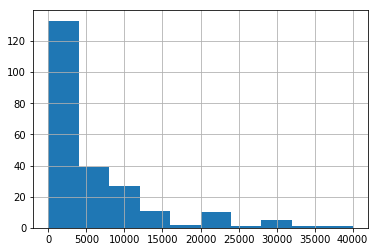

In [40]:
valid_store_density_df['density'].hist(bins=10)